In [2]:
import pandas as pd
import numpy as np
import glob
import os


def netlogo_data(path_to_netlogo_output, cloud_id):
    # Concatenate all the observations into one dataframe
    all_files = glob.glob(os.path.join(path_to_netlogo_output, "*.csv"))
    df = pd.concat((pd.read_csv(f, header=None) for f in all_files), ignore_index=True)
    
    df.columns = ['time_point', 'ID', 'xcoordinate', 'ycoordinate', 'apoptosis', 
                  'ERKactivity', 'Survival', 'ERKactivityValue', 'Wave_id']

    
    
    # Add noise to the positions and the activity values
    noise = pd.DataFrame(np.random.uniform(-0.5, 0.5, (df.shape[0], 3)))

    df['xcoordinate'] = df['xcoordinate'] + noise[0]
    df['xcoordinate'] = df['xcoordinate'].round(2)
    df['ycoordinate'] = df['xcoordinate'] + noise[1]
    df['ycoordinate'] = df['ycoordinate'].round(2)
    df['ERKactivityValue'] = df['xcoordinate'] + noise[2]
    df['ERKactivityValue'] = df['ERKactivityValue'].clip(lower=0).round(2)
    
    df['Cloud_id'] = cloud_id * np.ones((df.shape[0],))
    df['Cloud_id'] = df['Cloud_id'].astype('int')
    
    
    ##### FIND THE boxes 
    # Format: x_min, y_min, time_min, x_max, y_max, time_max
    
    boxes = pd.DataFrame(columns=['Cloud_id', 'Wave_id', 'x_min', 'y_min', 'time_min', 'x_max', 'y_max', 'time_max', 'time_diff'])
    
    # Remove the background
    waves = df['Wave_id'].unique()
    waves = waves[waves != -1]
    
    # Create boxes for the waves by ID
    for w in waves:
        wave = df[df['Wave_id'] == w]
        
        x_min = wave['xcoordinate'].min()
        y_min = wave['ycoordinate'].min()
        time_min = wave['time_point'].min()
        
        x_max = wave['xcoordinate'].max()
        y_max = wave['ycoordinate'].max()
        time_max = wave['time_point'].max()
        
        if time_max - time_min > 3:
            if time_max - time_min > 20:
                half_time = int((time_max - time_min)/2)
                wave = wave.sort_values(by=['time_point'])
                wave1 = wave.loc[wave['time_point'] <= time_min + half_time]
                wave1['Wave_id'] = str(w) + '.1'
                wave2 = wave.loc[wave['time_point'] >= time_min + half_time]
                wave2['Wave_id'] = str(w) + '.2'

                x_min1 = wave1['xcoordinate'].min()
                y_min1 = wave1['ycoordinate'].min()
                time_min1 = wave1['time_point'].min()
                x_max1 = wave1['xcoordinate'].max()
                y_max1 = wave1['ycoordinate'].max()
                time_max1 = wave1['time_point'].max()

                x_min2 = wave2['xcoordinate'].min()
                y_min2 = wave2['ycoordinate'].min()
                time_min2 = wave2['time_point'].min()
                x_max2 = wave2['xcoordinate'].max()
                y_max2 = wave2['ycoordinate'].max()
                time_max2 = wave2['time_point'].max()

                wave_box1 = pd.DataFrame([[cloud_id, str(w) + '.1', x_min1, y_min1, time_min1, x_max1, y_max1, time_max1, time_max1-time_min1]],
                                        columns=['Cloud_id', 'Wave_id', 'x_min', 'y_min', 'time_min', 'x_max', 'y_max', 'time_max', 'time_diff'])
                wave_box2 = pd.DataFrame([[cloud_id, str(w) + '.2', x_min2, y_min2, time_min2, x_max2, y_max2, time_max2, time_max2-time_min2]],
                                        columns=['Cloud_id', 'Wave_id', 'x_min', 'y_min', 'time_min', 'x_max', 'y_max', 'time_max', 'time_diff'])

                boxes = pd.concat([boxes, wave_box1], ignore_index=True)
                boxes = pd.concat([boxes, wave_box2], ignore_index=True)

            else: 
                wave_box = pd.DataFrame([[cloud_id, w, x_min, y_min, time_min, x_max, y_max, time_max, time_max-time_min]],
                                        columns=['Cloud_id', 'Wave_id', 'x_min', 'y_min', 'time_min', 'x_max', 'y_max', 'time_max', 'time_diff'])
                boxes = pd.concat([boxes, wave_box], ignore_index=True)
    
    df.to_csv(path_to_netlogo_output + '/dataset.csv', index=False)
    boxes.to_csv(path_to_netlogo_output + '/minmaxboxes.csv', index=False)
    
    return df, boxes




In [ ]:
path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo1'
cloud1_df, cloud1_boxes = netlogo_data(path_to_netlogo_output, 1)

awave = cloud1_df[cloud1_df['Wave_id'] == 473]

In [ ]:
###### FROM https://logicatcore.github.io/scratchpad/lidar/sensor-fusion/jupyter/2021/04/20/3D-Oriented-Bounding-Box.html


import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(awave['xcoordinate'], awave['ycoordinate'], awave['time_point'], label="original data")
ax.set_xlabel('x')
ax.set_ylabel('time')
ax.set_zlabel('y')
ax.legend()


def draw3DRectangle(ax, x1, y1, z1, x2, y2, z2):
    # the Translate the datatwo sets of coordinates form the apposite diagonal points of a cuboid
    ax.plot([x1, x2], [y1, y1], [z1, z1], color='b') # | (up)
    ax.plot([x2, x2], [y1, y2], [z1, z1], color='b') # -->
    ax.plot([x2, x1], [y2, y2], [z1, z1], color='b') # | (down)
    ax.plot([x1, x1], [y2, y1], [z1, z1], color='b') # <--

    ax.plot([x1, x2], [y1, y1], [z2, z2], color='b') # | (up)
    ax.plot([x2, x2], [y1, y2], [z2, z2], color='b') # -->
    ax.plot([x2, x1], [y2, y2], [z2, z2], color='b') # | (down)
    ax.plot([x1, x1], [y2, y1], [z2, z2], color='b') # <--
    
    ax.plot([x1, x1], [y1, y1], [z1, z2], color='b') # | (up)
    ax.plot([x2, x2], [y2, y2], [z1, z2], color='b') # -->
    ax.plot([x1, x1], [y2, y2], [z1, z2], color='b') # | (down)
    ax.plot([x2, x2], [y1, y1], [z1, z2], color='b') # <--

abox = cloud1_boxes[cloud1_boxes['Wave_id'] == 412]
draw3DRectangle(ax, abox['x_min'], abox['time_min'], abox['y_min'], abox['x_max'], abox['time_max'], abox['y_max'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
from mpl_toolkits.mplot3d import Axes3D

data = np.vstack([awave[['xcoordinate']].values.T, awave[['time_point']].values.T, awave[['ycoordinate']].values.T])
print(data.shape)

means = np.mean(data, axis=1)
cov = np.cov(data)
eval, evec = LA.eig(cov)
eval, evec


centered_data = data - means[:,np.newaxis]

np.allclose(LA.inv(evec), evec.T)

xmin, xmax, ymin, ymax, zmin, zmax = np.min(centered_data[0, :]), np.max(centered_data[0, :]), np.min(centered_data[1, :]), np.max(centered_data[1, :]), np.min(centered_data[2, :]), np.max(centered_data[2, :])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0,:], data[1,:], data[2,:], label="original data")
ax.scatter(centered_data[0,:], centered_data[1,:], centered_data[2,:], label="centered data")
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('time')
ax.set_zlabel('y')

# Code repeat end
draw3DRectangle(ax, xmin, ymin, zmin, xmax, ymax, zmax)


In [ ]:
aligned_coords = np.matmul(evec.T, centered_data)

xmin, xmax, ymin, ymax, zmin, zmax = np.min(aligned_coords[0, :]), np.max(aligned_coords[0, :]), np.min(aligned_coords[1, :]), np.max(aligned_coords[1, :]), np.min(aligned_coords[2, :]), np.max(aligned_coords[2, :])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(aligned_coords[0,:], aligned_coords[1,:], aligned_coords[2,:], color='g', label="rotated/aligned data")
ax.scatter(centered_data[0,:], centered_data[1,:], centered_data[2,:], color='tab:orange', label="centered data")
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('time')
ax.set_zlabel('y')


draw3DRectangle(ax, xmin, ymin, zmin, xmax, ymax, zmax)


In [ ]:
rectCoords = lambda x1, y1, z1, x2, y2, z2: np.array([[x1, x1, x2, x2, x1, x1, x2, x2],
                                                      [y1, y2, y2, y1, y1, y2, y2, y1],
                                                      [z1, z1, z1, z1, z2, z2, z2, z2]])

print(evec)


realigned_coords = np.matmul(evec, aligned_coords)
realigned_coords += means[:, np.newaxis]


rrc = np.matmul(evec, rectCoords(xmin, ymin, zmin, xmax, ymax, zmax))
# rrc = rotated rectangle coordinates


rrc += means[:, np.newaxis] 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(realigned_coords[0,:], realigned_coords[1,:], realigned_coords[2,:], label="rotation and translation undone")
ax.legend()

# z1 plane boundary
ax.plot(rrc[0, 0:2], rrc[1, 0:2], rrc[2, 0:2], color='b')
ax.plot(rrc[0, 1:3], rrc[1, 1:3], rrc[2, 1:3], color='b')
ax.plot(rrc[0, 2:4], rrc[1, 2:4], rrc[2, 2:4], color='b')
ax.plot(rrc[0, [3,0]], rrc[1, [3,0]], rrc[2, [3,0]], color='b')

# z2 plane boundary
ax.plot(rrc[0, 4:6], rrc[1, 4:6], rrc[2, 4:6], color='b')
ax.plot(rrc[0, 5:7], rrc[1, 5:7], rrc[2, 5:7], color='b')
ax.plot(rrc[0, 6:], rrc[1, 6:], rrc[2, 6:], color='b')
ax.plot(rrc[0, [7, 4]], rrc[1, [7, 4]], rrc[2, [7, 4]], color='b')

# z1 and z2 connecting boundaries
ax.plot(rrc[0, [0, 4]], rrc[1, [0, 4]], rrc[2, [0, 4]], color='b')
ax.plot(rrc[0, [1, 5]], rrc[1, [1, 5]], rrc[2, [1, 5]], color='b')
ax.plot(rrc[0, [2, 6]], rrc[1, [2, 6]], rrc[2, [2, 6]], color='b')
ax.plot(rrc[0, [3, 7]], rrc[1, [3, 7]], rrc[2, [3, 7]], color='b')

In [ ]:
from scipy.spatial.transform import Rotation

r = Rotation.from_matrix(evec)
#print(r.as_euler('zyx', degrees=True)) # intrinsic (angles based on the new cooridnate systems that are being built)
print(r.as_euler('ZYX', degrees=True)) # extrinsic (angles based on the original coordinate system)

In [3]:
import numpy as np
import numpy.linalg as LA
from scipy.spatial.transform import Rotation
import pandas as pd
import matplotlib.pyplot as plt



def box_calc(data):
    means = np.mean(data, axis=1)
    cov = np.cov(data)
    eval, evec = LA.eig(cov)
    eval, evec
    #print(evec)
    #print(LA.det(-evec))
    if LA.det(evec) < 0:
        evec = -evec

    
    centered_data = data - means[:,np.newaxis]
    np.allclose(LA.inv(evec), evec.T)
    aligned_coords = np.matmul(evec.T, centered_data)
    xmin, xmax, ymin, ymax, zmin, zmax = np.min(aligned_coords[0, :]), np.max(aligned_coords[0, :]), np.min(aligned_coords[1, :]), np.max(aligned_coords[1, :]), np.min(aligned_coords[2, :]), np.max(aligned_coords[2, :])
    rectCoords = lambda x1, y1, z1, x2, y2, z2: np.array([[x1, x1, x2, x2, x1, x1, x2, x2],
                                                      [y1, y2, y2, y1, y1, y2, y2, y1],
                                                      [z1, z1, z1, z1, z2, z2, z2, z2]])
    realigned_coords = np.matmul(evec, aligned_coords)
    realigned_coords += means[:, np.newaxis]
    rrc = np.matmul(evec, rectCoords(xmin, ymin, zmin, xmax, ymax, zmax))
    # rrc = rotated rectangle coordinates
    rrc += means[:, np.newaxis] 
    r = Rotation.from_matrix(evec)
    #print(r.as_matrix())
    # Get AABB in aligned frame
    xmin, xmax = np.min(aligned_coords[0, :]), np.max(aligned_coords[0, :])
    ymin, ymax = np.min(aligned_coords[1, :]), np.max(aligned_coords[1, :])
    zmin, zmax = np.min(aligned_coords[2, :]), np.max(aligned_coords[2, :])

    # Dimensions
    #width, length, height = xmax - xmin, ymax - ymin, zmax - zmin
    #print(width, length, height)
    
    # Center in aligned frame
    #center_aligned = np.array([xmin + width/2, ymin + length/2, zmin + height/2])
    center_aligned = np.array([(xmin + xmax)/2, (ymin + ymax)/2, (zmin + zmax)/2])

    # Convert center back to original coordinates
    center = np.dot(evec, center_aligned) + means

    #xmin, xmax = np.min(aligned_coords[0, 0:2]), np.max(aligned_coords[0, 0:2])
    #ymin, ymax = np.min(aligned_coords[1, 1:3]), np.max(aligned_coords[1, 1:3])
    #zmin, zmax = np.min(aligned_coords[2, 2:4]), np.max(aligned_coords[2, 2:4])

    width, length, height = xmax - xmin, ymax - ymin, zmax - zmin
    
    # Convert rotation matrix to Euler angles
    
    euler_angles = r.as_euler('ZYX', degrees=True).tolist()  # Ensure consistent rotation order

    return width, length, height, center, euler_angles, rrc, realigned_coords

def box_fig(rrc, b, realigned_coords, center):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(realigned_coords[0,:], realigned_coords[1,:], realigned_coords[2,:], label="rotation and translation undone")
    ax.scatter(center[0], center[1], center[2], color='red')
    ax.legend()
    ax.set_title(str(b))

    # z1 plane boundary
    ax.plot(rrc[0, 0:2], rrc[1, 0:2], rrc[2, 0:2], color='b')
    ax.plot(rrc[0, 1:3], rrc[1, 1:3], rrc[2, 1:3], color='b')
    ax.plot(rrc[0, 2:4], rrc[1, 2:4], rrc[2, 2:4], color='b')
    ax.plot(rrc[0, [3,0]], rrc[1, [3,0]], rrc[2, [3,0]], color='b')

    # z2 plane boundary
    ax.plot(rrc[0, 4:6], rrc[1, 4:6], rrc[2, 4:6], color='b')
    ax.plot(rrc[0, 5:7], rrc[1, 5:7], rrc[2, 5:7], color='b')
    ax.plot(rrc[0, 6:], rrc[1, 6:], rrc[2, 6:], color='b')
    ax.plot(rrc[0, [7, 4]], rrc[1, [7, 4]], rrc[2, [7, 4]], color='b')

    # z1 and z2 connecting boundaries
    ax.plot(rrc[0, [0, 4]], rrc[1, [0, 4]], rrc[2, [0, 4]], color='b')
    ax.plot(rrc[0, [1, 5]], rrc[1, [1, 5]], rrc[2, [1, 5]], color='b')
    ax.plot(rrc[0, [2, 6]], rrc[1, [2, 6]], rrc[2, [2, 6]], color='b')
    ax.plot(rrc[0, [3, 7]], rrc[1, [3, 7]], rrc[2, [3, 7]], color='b')

    return None

# function to calculate the euler angle boxes for a cloud
def euler_boxes(path_to_netlogo_output, cloud_id):
    df = pd.read_csv(path_to_netlogo_output + '/dataset.csv')
    minmaxboxes = pd.read_csv(path_to_netlogo_output + '/minmaxboxes.csv')

    boxes = pd.DataFrame(columns=['Cloud_id', 'Wave_id', 'width', 'length', 'height', 'center_x', 'center_y', 'center_z','euler_z', 'euler_y', 'euler_x'])
    

    
    # Remove the background
    waves = df['Wave_id'].unique()
    waves = waves[waves != -1]

    for b in waves:
        awave = df[df['Wave_id'] == b]

        time_min = awave['time_point'].min()
        time_max = awave['time_point'].max()

        if time_max - time_min > 3:
            if time_max - time_min > 20:
                half_time = int((time_max - time_min)/2)
                awave = awave.sort_values(by=['time_point'])
                wave1 = awave.loc[awave['time_point'] <= time_min + half_time]
                wave1['Wave_id'] = str(b) + '.1'
                wave2 = awave.loc[awave['time_point'] >= time_min + half_time]
                wave2['Wave_id'] = str(b) + '.2'

                data1 = np.vstack([wave1[['xcoordinate']].values.T, wave1[['time_point']].values.T, wave1[['ycoordinate']].values.T])
                width1, length1, height1, center1, euler_angles1, rrc1, realigned_coords1 = box_calc(data1)

                data2 = np.vstack([wave2[['xcoordinate']].values.T, wave2[['time_point']].values.T, wave2[['ycoordinate']].values.T])
                width2, length2, height2, center2, euler_angles2, rrc2, realigned_coords2 = box_calc(data2)


                wave_box1 = pd.DataFrame([[cloud_id, str(b) + '.1', width1, length1, height1, center1[0], center1[1], center1[2], euler_angles1[0], euler_angles1[1], euler_angles1[2]]],
                                    columns=['Cloud_id', 'Wave_id', 'width', 'length', 'height', 'center_x', 'center_y', 'center_z','euler_z', 'euler_y', 'euler_x'])

                wave_box2 = pd.DataFrame([[cloud_id, str(b) + '.2', width2, length2, height2, center2[0], center2[1], center2[2], euler_angles2[0], euler_angles2[1], euler_angles2[2]]],
                                    columns=['Cloud_id', 'Wave_id', 'width', 'length', 'height', 'center_x', 'center_y', 'center_z','euler_z', 'euler_y', 'euler_x'])

                #box_fig(rrc1, str(b) + '.1', realigned_coords1, center1)
                #box_fig(rrc2, str(b) + '.2', realigned_coords2, center2)


                boxes = pd.concat([boxes, wave_box1], ignore_index=True)
                boxes = pd.concat([boxes, wave_box2], ignore_index=True)

            else:
                data = np.vstack([awave[['xcoordinate']].values.T, awave[['time_point']].values.T, awave[['ycoordinate']].values.T])
                #print(data.shape)

                width, length, height, center, euler_angles, rrc, realigned_coords = box_calc(data)


                wave_box = pd.DataFrame([[cloud_id, b, width, length, height, center[0], center[1], center[2], euler_angles[0], euler_angles[1], euler_angles[2]]],
                                        columns=['Cloud_id', 'Wave_id', 'width', 'length', 'height', 'center_x', 'center_y', 'center_z','euler_z', 'euler_y', 'euler_x'])
                boxes = pd.concat([boxes, wave_box], ignore_index=True)

                #box_fig(rrc, b, realigned_coords, center)

    boxes.to_csv(path_to_netlogo_output + '/eulerboxes.csv', index=False)


        #r_box = pd.DataFrame([cloud_id, b, rrc.tolist()], columns=['Cloud_id', 'Wave_id', 'r'])
        #boxes_full.concat([boxes_full, r_box], ignore_index=True)
        

    return boxes

    

In [ ]:
path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo1'
cloud1_eulerboxes = euler_boxes(path_to_netlogo_output, 1)



In [19]:
clouds = list()
boxes = list()
for k in range(1, 19):

    path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo' + str(k)
    #cloud_df, cloud1_boxes = netlogo_data(path_to_netlogo_output, k)
    #clouds = clouds + tuple(cloud_df)
    
    #eulerboxes = euler_boxes(path_to_netlogo_output, k)
    #boxes = boxes + tuple(eulerboxes)
    #print(type(eulerboxes))

    print(k)

    cloud_df = pd.read_csv(path_to_netlogo_output + '/dataset.csv')
    clouds.append(cloud_df)
    print(clouds)
    print(type(cloud_df))

    eulerboxes = pd.read_csv(path_to_netlogo_output + '/eulerboxes.csv')
    boxes.append(eulerboxes)
    print(boxes)
    print(type(eulerboxes))



all_boxes = pd.concat(boxes)
all_boxes.to_csv('/Users/salina/Desktop/PointCNN/simulation_data/all_boxes.csv', index=False)


all_data = pd.concat(clouds)
all_data.to_csv('/Users/salina/Desktop/PointCNN/simulation_data/whole_dataset.csv', index=False)


1


[        time_point   ID  xcoordinate  ycoordinate  apoptosis  ERKactivity  \
0              155  466        13.30        13.15          0            1   
1              155  560        -2.21        -2.62          0            0   
2              155  503       -10.92       -11.23          0            0   
3              155  113        -5.67        -5.81          0            0   
4              155  183        -2.28        -1.80          0            0   
...            ...  ...          ...          ...        ...          ...   
161443         158  946        11.06        10.64          0            0   
161444         158  394       -10.01        -9.65          0            1   
161445         158  254         7.56         7.18          0            0   
161446         158  810         0.55         0.56          0            0   
161447         158  239        14.57        14.74          0            0   

        Survival  ERKactivityValue  Wave_id  Cloud_id  
0              1  

In [ ]:
path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo1'
dataset1 = pd.read_csv(path_to_netlogo_output + '/dataset.csv')


path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo2'
dataset2 = pd.read_csv(path_to_netlogo_output + '/dataset.csv')


path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo3'
dataset3 = pd.read_csv(path_to_netlogo_output + '/dataset.csv')


path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo4'
dataset4 = pd.read_csv(path_to_netlogo_output + '/dataset.csv')


path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo5'
dataset5 = pd.read_csv(path_to_netlogo_output + '/dataset.csv')


path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo6'
dataset6 = pd.read_csv(path_to_netlogo_output + '/dataset.csv')


all_data = pd.concat((dataset1, dataset2, dataset3, dataset4, dataset5, dataset6))
all_data.to_csv('/Users/salina/Desktop/PointCNN/simulation_data/whole_dataset.csv', index=False)

for x:
-3.0330559593404036 107.76194227968246 -178.97039233626288 167.74897094606263
for y:
15.629184943870987 35.33034054708518 -45.50305409174426 45.70046705739122
for z:
-1.7728165607415454 89.8519205387466 -179.96544567031322 179.98460807850998


<AxesSubplot:xlabel='euler_z', ylabel='Count'>

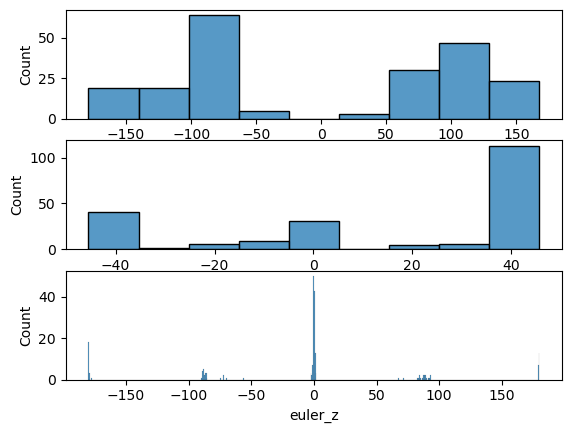

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


all_boxes = pd.read_csv('/Users/salina/Desktop/PointCNN/simulation_data/all_boxes.csv')

mean_x = np.nanmean(all_boxes['euler_x'])
mean_y = np.nanmean(all_boxes['euler_y'])
mean_z = np.nanmean(all_boxes['euler_z'])

sd_x = np.nanstd(all_boxes['euler_x'])
sd_y = np.nanstd(all_boxes['euler_y'])
sd_z = np.nanstd(all_boxes['euler_z'])

min_x, max_x = np.nanmin(all_boxes['euler_x']), np.nanmax(all_boxes['euler_x'])
min_y, max_y = np.nanmin(all_boxes['euler_y']), np.nanmax(all_boxes['euler_y'])
min_z, max_z = np.nanmin(all_boxes['euler_z']), np.nanmax(all_boxes['euler_z'])

print('for x:')
print(mean_x, sd_x, min_x, max_x)

print('for y:')
print(mean_y, sd_y, min_y, max_y)

print('for z:')
print(mean_z, sd_z, min_z, max_z)

fig, ax = plt.subplots(3)
sns.histplot(all_boxes['euler_x'], ax=ax[0])
sns.histplot(all_boxes['euler_y'], ax=ax[1])
sns.histplot(all_boxes['euler_z'], ax=ax[2])

In [3]:
mean_x = np.nanmean(all_boxes['width'])
mean_y = np.nanmean(all_boxes['length'])
mean_z = np.nanmean(all_boxes['height'])

sd_x = np.nanstd(all_boxes['width'])
sd_y = np.nanstd(all_boxes['length'])
sd_z = np.nanstd(all_boxes['height'])

min_x, max_x = np.nanmin(all_boxes['width']), np.nanmax(all_boxes['width'])
min_y, max_y = np.nanmin(all_boxes['length']), np.nanmax(all_boxes['length'])
min_z, max_z = np.nanmin(all_boxes['height']), np.nanmax(all_boxes['height'])

print('for x:')
print(mean_x, sd_x, min_x, max_x)

print('for y:')
print(mean_y, sd_y, min_y, max_y)

print('for z:')
print(mean_z, sd_z, min_z, max_z)

for x:
2.1344188519197327 2.805278467851882 0.2170951074081157 12.608726900128536
for y:
7.0409337209704175 4.36900861132694 0.0935286184400707 12.671547297618954
for z:
8.122817184606607 3.8444139498495487 0.2389865377848225 16.20071111610269


Index(['Cloud_id', 'Wave_id', 'width', 'length', 'height', 'center_x',
       'center_y', 'center_z', 'euler_z', 'euler_y', 'euler_x'],
      dtype='object')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([9])
<built-in method size of Tensor object at 0x7f970128f780>
tensor(11.8514, dtype=torch.float64) tensor(0.7207, dtype=torch.float64) tensor(6.9805, dtype=torch.float64)
tensor(13.1348, dtype=torch.float64) tensor(156.0733, dtype=torch.float64) tensor(13.1433, dtype=torch.float64)
tensor([[ 0.3271, -0.7155, -0.6173],
        [-0.8849, -0.0028, -0.4657],
        [ 0.3315,  0.6986, -0.6341]], dtype=torch.float64)
torch.DoubleTensor
torch.Size([3, 8])


/Users/salina/anaconda3/envs/codex/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:140: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Users/salina/anaconda3/envs/codex/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, n

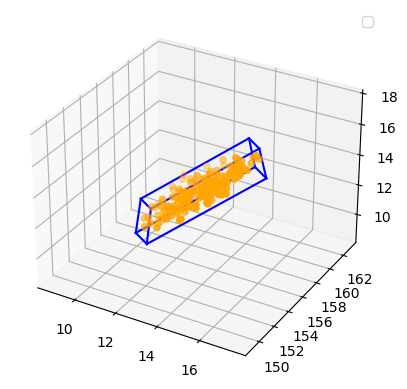

In [21]:
import torch
import numpy as np
import numpy.linalg as LA
from scipy.spatial.transform import Rotation
import pandas as pd
import matplotlib.pyplot as plt


path_to_netlogo_output = '/Users/salina/Desktop/PointCNN/simulation_data/Netlogo1'
cloud1_eulerboxes = pd.read_csv(path_to_netlogo_output + '/eulerboxes.csv')
print(cloud1_eulerboxes.columns)
cloud1 = pd.read_csv(path_to_netlogo_output + '/dataset.csv')

box1 = cloud1_eulerboxes.iloc[0,2:]
box1 = torch.tensor(box1.values)
cloud1 = cloud1.loc[cloud1['Wave_id'] == cloud1_eulerboxes.iloc[0,1]]
print(box1.shape)
print(box1.size)



def rotation_to_vertex(box):
    """
    Convert a box in format (width, lenght, height, [center], [euler angles])
    to the format of indicating all the vertices for pytorch3d iou computation.
    :param: box tensor(1,9): a box in format dimensions, center, euler angles
    """
#### TODO: maybe the tensor and the numpy will be needed to make uniformly
    w, l, h = box[:3]
    print(w, l, h)
    cx, cy, cz = box[3:6]
    euler_z, euler_y, euler_x = box[6:]
    print(cx, cy, cz)
    
    # Local vertices centered at the origin
    local_vertices = torch.tensor([
        [-w/2, -l/2, -h/2],
        [w/2, -l/2, -h/2],
        [w/2, l/2, -h/2],
        [-w/2, l/2, -h/2],
        [-w/2, -l/2, h/2],
        [w/2, -l/2, h/2],
        [w/2, l/2, h/2],
        [-w/2, l/2, h/2]
    ])
    
    # Rotation matrix
    r = Rotation.from_euler('ZYX', [euler_z, euler_y, euler_x], degrees=True).as_matrix()
    r = torch.from_numpy(r)
    print(r)
    
    # Rotate and translate vertices
    rotated_vertices = np.dot(local_vertices, r.T)
    final_vertices = torch.from_numpy(rotated_vertices) + torch.tensor([cx, cy, cz])
    
    return final_vertices

new_box = rotation_to_vertex(box1).T
print(new_box.type())
print(new_box.shape)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud1['xcoordinate'], cloud1['time_point'], cloud1['ycoordinate'], color='orange')
ax.legend()
#ax.set_title(str(b))
# z1 plane boundary
ax.plot(new_box[0, 0:2], new_box[1, 0:2], new_box[2, 0:2], color='b')
ax.plot(new_box[0, 1:3], new_box[1, 1:3], new_box[2, 1:3], color='b')
ax.plot(new_box[0, 2:4], new_box[1, 2:4], new_box[2, 2:4], color='b')
ax.plot(new_box[0, [3,0]], new_box[1, [3,0]], new_box[2, [3,0]], color='b')
# z2 plane boundary
ax.plot(new_box[0, 4:6], new_box[1, 4:6], new_box[2, 4:6], color='b')
ax.plot(new_box[0, 5:7], new_box[1, 5:7], new_box[2, 5:7], color='b')
ax.plot(new_box[0, 6:], new_box[1, 6:], new_box[2, 6:], color='b')
ax.plot(new_box[0, [7, 4]], new_box[1, [7, 4]], new_box[2, [7, 4]], color='b')
# z1 and z2 connecting boundaries
ax.plot(new_box[0, [0, 4]], new_box[1, [0, 4]], new_box[2, [0, 4]], color='b')
ax.plot(new_box[0, [1, 5]], new_box[1, [1, 5]], new_box[2, [1, 5]], color='b')
ax.plot(new_box[0, [2, 6]], new_box[1, [2, 6]], new_box[2, [2, 6]], color='b')
ax.plot(new_box[0, [3, 7]], new_box[1, [3, 7]], new_box[2, [3, 7]], color='b')



In [28]:
def vertex_to_rotation(box):
    """
    Convert a box in format (width, lenght, height, [center], [euler angles])
    to the format of indicating all the vertices for pytorch3d iou computation.
    :param: box tensor(1,24): a box in format dimensions, center, euler angles
    
    

    box_corner_vertices = [
        [0, 0, 0],          xmin, ymin, zmin
        [1, 0, 0],          xmax, ymin, zmin
        [1, 1, 0],          xmax, ymax, zmin
        [0, 1, 0],          xmin, ymax, zmin
        [0, 0, 1],          xmin, ymin, zmax
        [1, 0, 1],          xmax, ymin, zmax
        [1, 1, 1],          xmax, ymax, zmax
        [0, 1, 1],          xmin, ymax, zmax
    ]
    """
    box = box.view(8,3)

    xmin, xmax = torch.min(box[:,0]), torch.max(box[:,0])
    ymin, ymax = torch.min(box[:,1]), torch.max(box[:,1])
    zmin, zmax = torch.min(box[:,2]), torch.max(box[:,2])

    center = np.array([(xmin + xmax)/2, (ymin + ymax)/2, (zmin + zmax)/2])

    centered_box = box - center
    
    edges = np.array([
        centered_box[1] - centered_box[0],  # Edge along the width
        centered_box[3] - centered_box[0],  # Edge along the length
        centered_box[4] - centered_box[0]   # Edge along the height
    ])
    
    width = np.linalg.norm(edges[0])
    length = np.linalg.norm(edges[1])
    height = np.linalg.norm(edges[2])
    
    # Normalize edges to get the rotation matrix (relative to the standard axes)
    r = np.column_stack([edges[0]/width, edges[1]/length, edges[2]/height])

    # Ensure the rotation matrix is orthogonal
    u, _, vh = np.linalg.svd(r)
    r = np.dot(u, vh)

    # Convert the rotation matrix to Euler angles
    r = Rotation.from_matrix(r)
    euler_angles = r.as_euler('ZYX', degrees=True)
    
    
    box = torch.tensor([width, length, height, center[0], center[1], center[2], euler_angles[0], euler_angles[1], euler_angles[2]])
    
    return box




box2 = vertex_to_rotation(new_box.T)


tensor([[ 4.7382e-01,  6.8703e+00, -2.8732e-03],
        [ 4.3507e+00, -3.6173e+00,  3.9259e+00],
        [ 3.8350e+00, -3.6194e+00,  4.4293e+00],
        [-4.1830e-02,  6.8683e+00,  5.0057e-01],
        [-3.8350e+00,  3.6194e+00, -4.4293e+00],
        [ 4.1830e-02, -6.8683e+00, -5.0057e-01],
        [-4.7382e-01, -6.8703e+00,  2.8732e-03],
        [-4.3507e+00,  3.6173e+00, -3.9259e+00]], dtype=torch.float64)
tensor([ 4.7382e-01,  6.8703e+00, -2.8732e-03], dtype=torch.float64)
[[ 0.32712093 -0.71552558 -0.61726415]
 [-0.88492974 -0.002808   -0.46571608]
 [ 0.33149849  0.69858089 -0.63410842]]


/var/folders/w3/fypmw2x53db9kt22d9wrd_1h0000gn/T/ipykernel_9827/130184935.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  edges = np.array([
/var/folders/w3/fypmw2x53db9kt22d9wrd_1h0000gn/T/ipykernel_9827/130184935.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  edges = np.array([
